#Calling Liabraries

In [1]:
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import os
pd.set_option('display.max_columns',50)
pd.set_option('display.float_format', lambda x: '%.5f'%x)

#for date  manipulation
from datetime import datetime

# for vislalization
import matplotlib.pyplot as plt
 # to display visuals in the notebook
%matplotlib inline

import seaborn as sns
sns.set_context(font_scale=2)
sns.set_style("darkgrid")

# for feature engineering: itertools
from itertools import combinations

# for data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for building the model and calculate RMSE
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
    
from sklearn.model_selection import KFold


# to cleanup memory usage
import gc

#Calling Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/EETBS 2021-2022/Course Project Files/RAZA_AL GAZALI/Data"
Weather_train_name = "weather_train.csv"
Train_name = "train.csv"
Buidling_name = "building_metadata.csv"

In [7]:
Building_data_path = os.path.join(path, Buidling_name)
weather_data_path = os.path.join(path,Weather_train_name)
Train_path = os.path.join(path,Train_name)

In [8]:
Building_data = pd.read_csv(Building_data_path,sep=",")
Weather_data = pd.read_csv(weather_data_path,sep = ",", parse_dates = True)
Train_data = pd.read_csv(Train_path,sep = ",", parse_dates = True)

#Memory reduction

In [9]:
## Function to reduce the DF size
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [10]:
reduce_memory_usage(Building_data)
reduce_memory_usage(Weather_data)
reduce_memory_usage(Train_data)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)


#Understanding Data

In [13]:
Train_data.tail(50)

,building_id,meter,timestamp,meter_reading
20216050,1413,2,2016-12-31 23:00:00,459.83301
20216051,1414,0,2016-12-31 23:00:00,70.65000
20216052,1414,2,2016-12-31 23:00:00,2420.78003
20216053,1415,0,2016-12-31 23:00:00,12.25000
20216054,1416,0,2016-12-31 23:00:00,12.02500
20216055,1417,0,2016-12-31 23:00:00,79.35000
20216056,1417,2,2016-12-31 23:00:00,32.64290
20216057,1418,0,2016-12-31 23:00:00,13.17500
20216058,1418,2,2016-12-31 23:00:00,517.05902
20216059,1419,0,2016-12-31 23:00:00,7.42500


In [14]:
Weather_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.00000,6.00000,20.00000,NaN,1019.50000,0.00000,0.00000
1,0,2016-01-01 01:00:00,24.40625,NaN,21.09375,-1.00000,1020.00000,70.00000,1.50000
2,0,2016-01-01 02:00:00,22.79688,2.00000,21.09375,0.00000,1020.00000,0.00000,0.00000
3,0,2016-01-01 03:00:00,21.09375,2.00000,20.59375,0.00000,1020.00000,0.00000,0.00000
4,0,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.59961


In [15]:
Building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.00000,NaN
1,0,1,Education,2720,2004.00000,NaN
2,0,2,Education,5376,1991.00000,NaN
3,0,3,Education,23685,2002.00000,NaN
4,0,4,Education,116607,1975.00000,NaN


In [16]:
Building_data.drop(columns=["floor_count"],inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


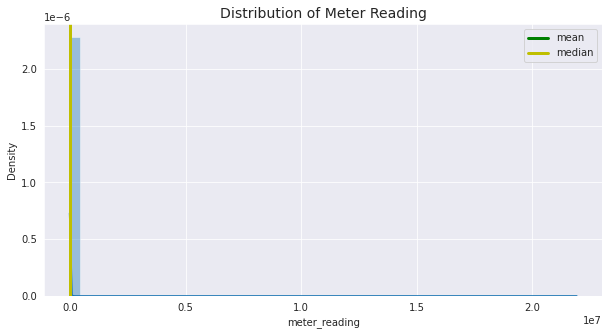

In [17]:
plt.figure(figsize=(10,5))

#set the histogram, mean and median
sns.distplot(Train_data['meter_reading'], kde=True) # kernel density estimate (KDE) plot
plt.axvline(x=Train_data.meter_reading.mean(), linewidth=3, color='g',label='mean')
plt.axvline(x=Train_data.meter_reading.median(), linewidth=3, color='y', label='median')

plt.title('Distribution of Meter Reading', size=14)
plt.legend()

#From the below graph it can be seen that the distribution highly skewed. 
#Also, the values are highly concentrted close to 0
#To avoid the highly skewed data the natural log(1 + meter_reading) will be visualized using np.log1p. This enables us to transform 0 to 1. 
#As the natural logarithm of zero is minus infinity (a real number to the power of some real number is never 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


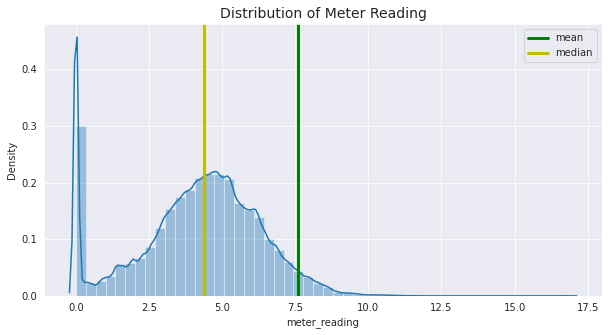

In [18]:
# log transformed plot
plt.figure(figsize=(10,5))

#set the histogram, mean and median
sns.distplot(np.log1p(Train_data['meter_reading']), kde=True)   #np.log1p  is the log transformation(log(x+1))
plt.axvline(x=np.log1p(Train_data.meter_reading.mean()), linewidth=3, color='g',label='mean')
plt.axvline(x=np.log1p(Train_data.meter_reading.median()), linewidth=3, color='y', label='median')

plt.title('Distribution of Meter Reading', size=14)
plt.legend()
#Generally if the distribution of data is skewed to the left, the mean is less than the median, which is often less than the mode.
#If the distribution of data is skewed to the right, the mode is often less than the median, which is less than the mean
#from the graph above we can see that mean > median that means the distribution is right skewed.
#This skewness is caused by the significanlty high number of 0 and 1 measurements in the meter_reading. 
#Let's look at the definition if we can get some logical explanation to 0 measurements:
#They are the Energy consumption in kWh (or equivalent). This is the real data with measurement error, which we expect will impose a baseline level of modeling error.
#meaning : this is the real data with some errors or missing values in the meter_reading.
#Thus high number of 0 meter reading values shows not only zero consumption but may indicate some missing data in the meter_reading. 
#Moving on with this suspicion, let's see how the distribution will look like if we exclude 0 measurements from the dataset.
#And also if we visulaize it is impossible for any building to consume 0 at a given time because there will be atleast some appliances connected.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


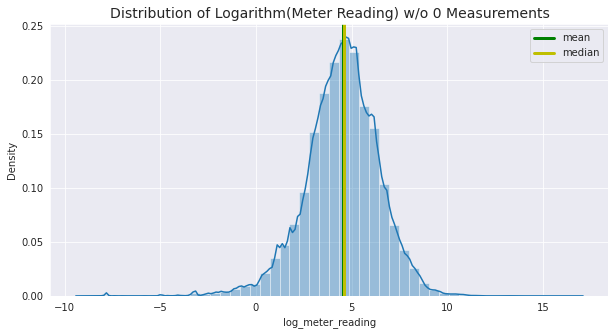

In [19]:
positive_train = Train_data[Train_data['meter_reading']!=0]
positive_train['log_meter_reading'] = np.log(positive_train['meter_reading'])
# plotting the meter_reading with positive values.
plt.figure(figsize=(10,5))

#set the histogram, mean and median
sns.distplot(positive_train['log_meter_reading'], kde=True )  #np.log1p  is the log transformation(log(x+1))
plt.axvline(x=positive_train.log_meter_reading.mean(), linewidth=3, color='g',label='mean')
plt.axvline(x=positive_train.log_meter_reading.median(), linewidth=3, color='y', label='median')

plt.title('Distribution of Logarithm(Meter Reading) w/o 0 Measurements', size=14)
plt.legend()
#Now, it is more evident that 0 observations represents missing values.
#After dropping the zero values and taking the logarithm of the meter reading values, distribution shows a perfect normal distribution. 
#Data is centered around the mean. Mean and median values are equal to each other. Taking the logarithm helped to lower the variance.
#Moreover, some immediately observed outliers for log_meter_reading are around -7 and -5 and greater than 10. Let's have a closer look at the outliers:

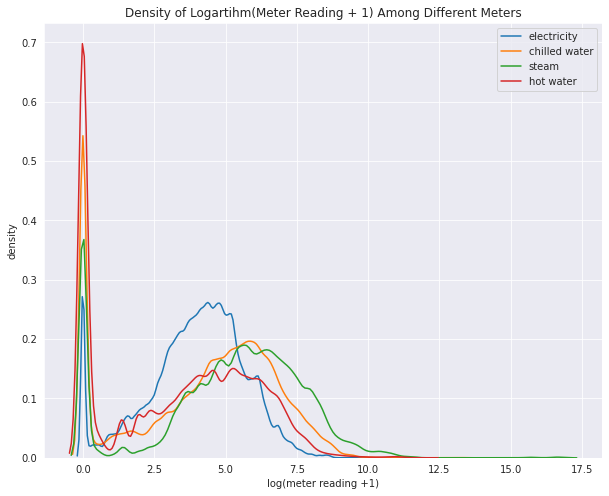

In [20]:
plt.figure(figsize=(10,8))

meters = np.unique(Train_data['meter'])

for meter in meters:
    subset = Train_data.loc[Train_data['meter']==meter,'meter_reading']
    sns.kdeplot(np.log1p(subset),label =meter)
plt.ylabel('density')
plt.xlabel('log(meter reading +1)')
plt.title('Density of Logartihm(Meter Reading + 1) Among Different Meters', fontsize=12)
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
#for the better visualisation we took log(x+1) of the meter reading.
#the readings of chilled water, steam and electricity are less skewed towards zero, meaning we have less missing values and 0 observations in the electricity usage.
#This picture shows that meter reading values shows different distribution in each meter category, especially electricity consumption is different than others. 
#Thus, meter is a signifcant variable to determine the meter_reading values. It is already included in the train and test dataset as a determinant factor.
#Let's visualize the meter reading values excluding 0 measurements for different meter categories using the dataset created earlier.

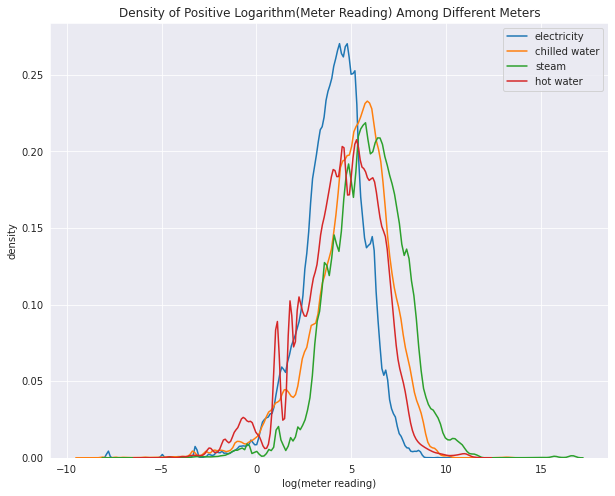

In [21]:
# distribution of the meter reading in meters with zeros

plt.figure(figsize=(10,8))

meters = np.unique(positive_train['meter'])

for meter in meters:
    subset = positive_train.loc[positive_train['meter']==meter,'meter_reading']
    sns.kdeplot(np.log(subset),label =meter)
plt.ylabel('density')
plt.xlabel('log(meter reading)')
plt.title('Density of Positive Logarithm(Meter Reading) Among Different Meters', fontsize=12)
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
#Electricity shows a slightly different distribution than other categories.
#Chilled water and steam meter_reading shows similar distributions with close mean values.
#Hot water has the least number of datapoints and has more spikes than the other categories.

#Feature Engineering

In [22]:
def add_lag_feature(Weather_data, window=3):  
    group_df = Weather_data.groupby('site_id')
    cols = ['air_temperature', 'dew_temperature',]
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float32)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        Weather_data[f'{col}_mean_lag{window}'] = lag_mean[col]

In [23]:
add_lag_feature(Weather_data, window=3)

In [24]:
Weather_data

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3
0,0,2016-01-01 00:00:00,25.00000,6.00000,20.00000,NaN,1019.50000,0.00000,0.00000,25.00000,20.00000
1,0,2016-01-01 01:00:00,24.40625,NaN,21.09375,-1.00000,1020.00000,70.00000,1.50000,24.70312,20.54688
2,0,2016-01-01 02:00:00,22.79688,2.00000,21.09375,0.00000,1020.00000,0.00000,0.00000,24.06771,20.72917
3,0,2016-01-01 03:00:00,21.09375,2.00000,20.59375,0.00000,1020.00000,0.00000,0.00000,22.76562,20.92708
4,0,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.59961,21.29688,20.56250
...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.00000,NaN,-8.00000,NaN,NaN,180.00000,5.69922,2.66667,-7.86719
139769,15,2016-12-31 20:00:00,2.80078,2.00000,-8.89844,NaN,1007.50000,180.00000,7.69922,2.86719,-8.23307
139770,15,2016-12-31 21:00:00,2.80078,NaN,-7.19922,NaN,1007.50000,180.00000,5.10156,2.86719,-8.03255
139771,15,2016-12-31 22:00:00,2.19922,NaN,-6.69922,NaN,1008.00000,170.00000,4.60156,2.60026,-7.59896


In [25]:
Train_data["timestamp"] = pd.to_datetime(Train_data["timestamp"])
Weather_data["timestamp"] = pd.to_datetime(Weather_data["timestamp"])

In [26]:
Train_data.head(50)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.00000
1,1,0,2016-01-01,0.00000
2,2,0,2016-01-01,0.00000
3,3,0,2016-01-01,0.00000
4,4,0,2016-01-01,0.00000
5,5,0,2016-01-01,0.00000
6,6,0,2016-01-01,0.00000
7,7,0,2016-01-01,0.00000
8,8,0,2016-01-01,0.00000
9,9,0,2016-01-01,0.00000


In [27]:
Train_data.tail(50)

,building_id,meter,timestamp,meter_reading
20216050,1413,2,2016-12-31 23:00:00,459.83301
20216051,1414,0,2016-12-31 23:00:00,70.65000
20216052,1414,2,2016-12-31 23:00:00,2420.78003
20216053,1415,0,2016-12-31 23:00:00,12.25000
20216054,1416,0,2016-12-31 23:00:00,12.02500
20216055,1417,0,2016-12-31 23:00:00,79.35000
20216056,1417,2,2016-12-31 23:00:00,32.64290
20216057,1418,0,2016-12-31 23:00:00,13.17500
20216058,1418,2,2016-12-31 23:00:00,517.05902
20216059,1419,0,2016-12-31 23:00:00,7.42500


In [28]:
Weather_data.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3
139768,15,2016-12-31 19:00:00,3.00000,NaN,-8.00000,NaN,NaN,180.00000,5.69922,2.66667,-7.86719
139769,15,2016-12-31 20:00:00,2.80078,2.00000,-8.89844,NaN,1007.50000,180.00000,7.69922,2.86719,-8.23307
139770,15,2016-12-31 21:00:00,2.80078,NaN,-7.19922,NaN,1007.50000,180.00000,5.10156,2.86719,-8.03255
139771,15,2016-12-31 22:00:00,2.19922,NaN,-6.69922,NaN,1008.00000,170.00000,4.60156,2.60026,-7.59896
139772,15,2016-12-31 23:00:00,1.70020,NaN,-5.60156,-1.00000,1008.50000,180.00000,8.79688,2.23340,-6.50000


In [29]:
Train_data.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [30]:
Weather_data.isnull().sum()

site_id                          0
timestamp                        0
air_temperature                 55
cloud_coverage               69173
dew_temperature                113
precip_depth_1_hr            50289
sea_level_pressure           10618
wind_direction                6268
wind_speed                     304
air_temperature_mean_lag3       21
dew_temperature_mean_lag3       24
dtype: int64

In [31]:
Building_data.isnull().sum()

site_id          0
building_id      0
primary_use      0
square_feet      0
year_built     774
dtype: int64

In [32]:
current_year = datetime.now().year
Building_data["age"] = current_year - Building_data['year_built']
Building_data.drop(columns = ["year_built"],axis = 1, inplace = True)

In [33]:
Building_data.fillna(value=round(Building_data['age'].mean(),0),inplace = True)

In [34]:
Building_data.head(50)

,site_id,building_id,primary_use,square_feet,age
0,0,0,Education,7432,14.00000
1,0,1,Education,2720,18.00000
2,0,2,Education,5376,31.00000
3,0,3,Education,23685,20.00000
4,0,4,Education,116607,47.00000
5,0,5,Education,8000,22.00000
6,0,6,Lodging/residential,27926,41.00000
7,0,7,Education,121074,33.00000
8,0,8,Education,60809,19.00000
9,0,9,Office,27000,12.00000


In [35]:
Building_data.isnull().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
age            0
dtype: int64

In [36]:
le = LabelEncoder()
le_primary_use = le.fit_transform(Building_data['primary_use'])

Building_data['primary_use'] = le_primary_use

del le, le_primary_use
gc.collect()

77

In [37]:
Weather_data['month'] = Weather_data['timestamp'].dt.month.astype(np.int8)  # January=1, December=12.
Weather_data['day_of_week'] = Weather_data['timestamp'].dt.dayofweek.astype(np.int8) #Monday=0, Sunday=6 
Weather_data['day_of_month'] = Weather_data['timestamp'].dt.day.astype(np.int8)
Weather_data['hour'] = Weather_data['timestamp'].dt.hour  # 0 to 23 hours
Weather_data['is_weekend'] = Weather_data.day_of_week.apply(lambda x : 1 if x>=5 else 0) 

In [38]:
def convert_season(month):
    if (month<=2) | (month==12):    # winter Season
        return 0
    elif (month >=3) & (month<=5 ): # Spring Season
        return 1
    elif (month >=6) & (month<=8 ):   # Summer Season
        return 2
    elif (month>=9) & (month <=11) : # Fall Season
        return 3

In [39]:
Weather_data['season'] = Weather_data.month.apply(convert_season)

In [40]:
weather_train = Weather_data.set_index(['site_id','day_of_month','month'])

In [41]:
weather_train.head(50)

timestamp  air_temperature  \
site_id day_of_month month                                        
0       1            1     2016-01-01 00:00:00         25.00000   
                     1     2016-01-01 01:00:00         24.40625   
                     1     2016-01-01 02:00:00         22.79688   
                     1     2016-01-01 03:00:00         21.09375   
                     1     2016-01-01 04:00:00         20.00000   
                     1     2016-01-01 05:00:00         19.40625   
                     1     2016-01-01 06:00:00         21.09375   
                     1     2016-01-01 07:00:00         21.09375   
                     1     2016-01-01 08:00:00         20.59375   
                     1     2016-01-01 09:00:00         21.09375   
                     1     2016-01-01 10:00:00         21.09375   
                     1     2016-01-01 11:00:00         20.59375   
                     1     2016-01-01 12:00:00         18.90625   
                     1     2016-01-01 13:00:00         20.00000   
                     1     2016-01-01 14:00:00         21.70312   
                     1     2016-01-01 15:00:00         23.90625   
                     1     2016-01-01 16:00:00         26.09375   
                     1     2016-01-01 17:00:00         26.70312   
                     1     2016-01-01 18:00:00         27.79688   
                     1     2016-01-01 19:00:00         28.29688   
                     1     2016-01-01 20:00:00         28.29688   
                     1     2016-01-01 21:00:00         27.79688   
                     1     2016-01-01 22:00:00         26.70312   
                     1     2016-01-01 23:00:00         25.59375   
        2            1     2016-01-02 00:00:00         24.40625   
                     1     2016-01-02 01:00:00         23.90625   
                     1     2016-01-02 02:00:00         22.20312   
                     1     2016-01-02 03:00:00         21.09375   
                     1     2016-01-02 04:00:00         20.59375   
                     1     2016-01-02 05:00:00         19.40625   
                     1     2016-01-02 06:00:00         18.90625   
                     1     2016-01-02 07:00:00         18.90625   
                     1     2016-01-02 08:00:00         18.90625   
                     1     2016-01-02 09:00:00         18.29688   
                     1     2016-01-02 10:00:00         18.90625   
                     1     2016-01-02 11:00:00         16.70312   
                     1     2016-01-02 12:00:00         15.60156   
                     1     2016-01-02 13:00:00         15.00000   
                     1     2016-01-02 14:00:00         16.09375   
                     1     2016-01-02 15:00:00         17.20312   
                     1     2016-01-02 16:00:00         17.79688   
                     1     2016-01-02 17:00:00         19.40625   
                     1     2016-01-02 18:00:00         20.59375   
                     1     2016-01-02 19:00:00         22.20312   
                     1     2016-01-02 20:00:00         22.79688   
                     1     2016-01-02 21:00:00         21.09375   
                     1     2016-01-02 22:00:00         20.00000   
                     1     2016-01-02 23:00:00         18.90625   
        3            1     2016-01-03 00:00:00         17.79688   
                     1     2016-01-03 01:00:00         16.70312   

                            cloud_coverage  dew_temperature  \
site_id day_of_month month                                    
0       1            1             6.00000         20.00000   
                     1                 NaN         21.09375   
                     1             2.00000         21.09375   
                     1             2.00000         20.59375   
                     1             2.00000         20.00000   
                     1                 NaN         19.40625   
                     1             6.00000      

#Missing data filling

This method of filling data is available at the data source website

In [42]:
air_temperature_filler = pd.DataFrame(weather_train.groupby(['site_id','day_of_month','month'])
                                      ['air_temperature'].mean(),
                                      columns=["air_temperature"])
print(air_temperature_filler.isna().sum())
print(air_temperature_filler.head())

air_temperature    0
dtype: int64
                            air_temperature
site_id day_of_month month                 
0       1            1             23.34375
                     2             20.50000
                     3             19.20312
                     4             25.65625
                     5             25.28125


In [43]:
# create dataframe of air_temperature to fill
temporary_df = pd.DataFrame({'air_temperature': weather_train.air_temperature})

#update NA air_temperature values
temporary_df.update(air_temperature_filler, overwrite=False)
print(temporary_df.head())

# update in the weather train dataset
weather_train['air_temperature'] = temporary_df['air_temperature']

                            air_temperature
site_id day_of_month month                 
0       1            1             25.00000
                     1             24.40625
                     1             22.79688
                     1             21.09375
                     1             20.00000


In [44]:
del temporary_df, air_temperature_filler
gc.collect()

50

In [45]:
# create dataframe of daily means per site id
cloud_coverage_filler = pd.DataFrame(weather_train
                                         .groupby(['site_id','day_of_month','month'])
                                                    ['cloud_coverage'].mean(),
                                     columns=['cloud_coverage'])
cloud_coverage_filler.isna().sum()

cloud_coverage    1075
dtype: int64

In [46]:
round(cloud_coverage_filler.cloud_coverage.mean(),0)

2.0

In [47]:
cloud_coverage_filler.fillna( round(cloud_coverage_filler.cloud_coverage.mean(),0),
                              inplace=True)

#create dataframe of cloud coverage to fill
temporary_df = pd.DataFrame({'cloud_coverage' : weather_train.cloud_coverage})

# update NA cloud_coverage values
temporary_df.update(cloud_coverage_filler, overwrite=False)

#update in the weather train dataset
weather_train['cloud_coverage'] = temporary_df['cloud_coverage']

del temporary_df, cloud_coverage_filler
gc.collect()

0

In [48]:
dew_temperature_filler = pd.DataFrame(weather_train
                                         .groupby(['site_id','day_of_month','month'])['dew_temperature'].mean(),
                                     columns=['dew_temperature'])
dew_temperature_filler.isnull().sum()

dew_temperature    0
dtype: int64

In [49]:
#create dataframe of dew_temperatures to fill
temporary_df = pd.DataFrame({'dew_temperature':weather_train.dew_temperature})

#update NA dew_temperature values
temporary_df.update(dew_temperature_filler, overwrite=False)

#update in the weather train dataset
weather_train['dew_temperature'] = temporary_df['dew_temperature']

del temporary_df, dew_temperature_filler
gc.collect()

0

In [50]:
# create filler dataframe for precip_depth_1_hr

precip_depth_filler = pd.DataFrame(weather_train
                                   .groupby(['site_id','day_of_month','month'])['precip_depth_1_hr'].mean(),
                                  columns=['precip_depth_1_hr'])

precip_depth_filler.isnull().sum()

precip_depth_1_hr    1709
dtype: int64

In [51]:
precip_depth_filler.fillna(round(precip_depth_filler.precip_depth_1_hr.mean(), 0),
                           inplace=True)

# create dataframe of precip_depth_1_hr to fill
temporary_df = pd.DataFrame({'precip_depth_1_hr': weather_train.precip_depth_1_hr})

#update NA precip_depth_1_hr values
temporary_df.update(precip_depth_filler, overwrite=False)

weather_train['precip_depth_1_hr'] = temporary_df.precip_depth_1_hr

del temporary_df, precip_depth_filler
gc.collect()

0

In [52]:
# create dataframe of daily means per site id
sea_level_filler = pd.DataFrame(weather_train
                                .groupby(['site_id','day_of_month','month'])
                                ['sea_level_pressure'].mean(),
                                columns=['sea_level_pressure'])
sea_level_filler.isna().sum()

sea_level_pressure    375
dtype: int64

In [53]:
mean_sea_level_pressure = round(
                                sea_level_filler
                                ['sea_level_pressure']
                                .astype(float)
                                .mean(),2)

In [54]:
sea_level_filler.fillna(mean_sea_level_pressure, inplace=True)

# create dataframe of sea_level_pressure to fill
temporary_df = pd.DataFrame({'sea_level_pressure' : weather_train.sea_level_pressure})

# update NA sea_level_pressure values
temporary_df.update(sea_level_filler, overwrite=False)

# update in the weather train dataset
weather_train["sea_level_pressure"] = temporary_df["sea_level_pressure"]

del sea_level_filler, temporary_df
gc.collect()

0

In [55]:
# create dataframe of daily means per site id
wind_direction_filler = pd.DataFrame(weather_train
                                     .groupby(['site_id','day_of_month','month'])
                                     ['wind_direction'].mean(),
                                     columns=['wind_direction'])
wind_direction_filler.isna().sum()

wind_direction    0
dtype: int64

In [56]:
wind_direction_filler.head(10)

wind_direction
site_id day_of_month month                
0       1            1           122.93750
                     2            92.62500
                     3           111.68750
                     4           185.37500
                     5           116.93750
                     6            80.50000
                     7           185.25000
                     8           122.06250
                     9           143.75000
                     10          120.43750

In [57]:
# create dataframe of wind_direction to fill
temporary_df = pd.DataFrame({'wind_direction' : weather_train.wind_direction})

# update NA wind_direction values
temporary_df.update(wind_direction_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_direction"] = temporary_df["wind_direction"]

In [58]:
temporary_df.head(20)

wind_direction
site_id day_of_month month                
0       1            1             0.00000
                     1            70.00000
                     1             0.00000
                     1             0.00000
                     1           250.00000
                     1             0.00000
                     1             0.00000
                     1           210.00000
                     1             0.00000
                     1           290.00000
                     1             0.00000
                     1             0.00000
                     1           210.00000
                     1             0.00000
                     1             0.00000
                     1           210.00000
                     1           210.00000
                     1           230.00000
                     1           200.00000
                     1           180.00000

In [59]:
del temporary_df, wind_direction_filler
gc.collect()

100

In [60]:
# create dataframe of daily means per site id
wind_speed_filler = pd.DataFrame(weather_train
                                 .groupby(['site_id','day_of_month','month'])
                                 ['wind_speed'].mean(),
                                 columns=['wind_speed'])
wind_speed_filler.isna().sum()

wind_speed    0
dtype: int64

In [61]:
# create dataframe of wind_speed to fill
temporary_df = pd.DataFrame({'wind_speed' : weather_train.wind_speed})

# update NA wind_speed values
temporary_df.update(wind_speed_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_speed"] = temporary_df["wind_speed"]

del temporary_df, wind_speed_filler
gc.collect()

0

In [62]:
# check if NA values left
weather_train.isnull().sum()

timestamp                     0
air_temperature               0
cloud_coverage                0
dew_temperature               0
precip_depth_1_hr             0
sea_level_pressure            0
wind_direction                0
wind_speed                    0
air_temperature_mean_lag3    21
dew_temperature_mean_lag3    24
day_of_week                   0
hour                          0
is_weekend                    0
season                        0
dtype: int64

In [63]:
weather_train = weather_train.reset_index()

In [64]:
weather_train.head()

,site_id,day_of_month,month,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3,day_of_week,hour,is_weekend,season
0,0,1,1,2016-01-01 00:00:00,25.00000,6.00000,20.00000,-0.17395,1019.50000,0.00000,0.00000,25.00000,20.00000,4,0,0,0
1,0,1,1,2016-01-01 01:00:00,24.40625,4.28516,21.09375,-1.00000,1020.00000,70.00000,1.50000,24.70312,20.54688,4,1,0,0
2,0,1,1,2016-01-01 02:00:00,22.79688,2.00000,21.09375,0.00000,1020.00000,0.00000,0.00000,24.06771,20.72917,4,2,0,0
3,0,1,1,2016-01-01 03:00:00,21.09375,2.00000,20.59375,0.00000,1020.00000,0.00000,0.00000,22.76562,20.92708,4,3,0,0
4,0,1,1,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.59961,21.29688,20.56250,4,4,0,0


In [65]:
def convert_direction(degrees):
    if degrees <= 90:
        return 0
    # as norteast direction
    elif degrees <= 180:
        return 1
    # as southeast direction
    elif degrees <= 270:
        return 2
    # as southwest direction
    elif degrees <= 360:
        return 3
    # as northwest direction

In [66]:
weather_train['wind_compass_direction'] = weather_train.wind_direction.apply(convert_direction)
weather_train.drop(columns='wind_direction',inplace=True)

#data of my interest

In [67]:
Train_data.set_index(['meter'],inplace = True)
Train_data.drop([0,2,3], inplace = True)

#Merged Data

In [68]:
train = Train_data.merge(Building_data, on='building_id', how='left')

In [69]:
train = train.merge(weather_train, on=['site_id','timestamp'], how='left')
train

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,age,day_of_month,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3,day_of_week,hour,is_weekend,season,wind_compass_direction
0,161,2016-01-01 00:00:00,0.00000,2,0,11329,54.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000
1,162,2016-01-01 00:00:00,0.00000,2,0,98829,54.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000
2,163,2016-01-01 00:00:00,4.57190,2,0,72102,52.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000
3,166,2016-01-01 00:00:00,209.88600,2,4,553210,13.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000
4,167,2016-01-01 00:00:00,0.00000,2,4,86323,66.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182435,1409,2016-12-31 23:00:00,18.81200,15,4,48881,120.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000
4182436,1410,2016-12-31 23:00:00,16.70000,15,6,11524,28.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000
4182437,1411,2016-12-31 23:00:00,0.00000,15,0,9111,64.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000
4182438,1412,2016-12-31 23:00:00,0.00000,15,4,39538,69.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000


In [70]:
print('Number of unique columns in a train dataset', train.shape[1])

Number of unique columns in a train dataset 22


In [71]:
train.isnull().sum()

building_id                      0
timestamp                        0
meter_reading                    0
site_id                          0
primary_use                      0
square_feet                      0
age                              0
day_of_month                 22347
month                        22347
air_temperature              22347
cloud_coverage               22347
dew_temperature              22347
precip_depth_1_hr            22347
sea_level_pressure           22347
wind_speed                   22347
air_temperature_mean_lag3    22539
dew_temperature_mean_lag3    22566
day_of_week                  22347
hour                         22347
is_weekend                   22347
season                       22347
wind_compass_direction       22347
dtype: int64

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182440 entries, 0 to 4182439
Data columns (total 22 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   building_id                int16         
 1   timestamp                  datetime64[ns]
 2   meter_reading              float32       
 3   site_id                    int8          
 4   primary_use                int64         
 5   square_feet                int32         
 6   age                        float32       
 7   day_of_month               float64       
 8   month                      float64       
 9   air_temperature            float16       
 10  cloud_coverage             float16       
 11  dew_temperature            float16       
 12  precip_depth_1_hr          float16       
 13  sea_level_pressure         float16       
 14  wind_speed                 float16       
 15  air_temperature_mean_lag3  float32       
 16  dew_temperature_mean_lag3  float32  

#Correlation

In [73]:
correlations_transformed = train.corr()

In [74]:
# use only 'meter_reading' column
correlations_transformed = pd.DataFrame(correlations_transformed['meter_reading']).reset_index()

# format the column names
correlations_transformed.columns = ['Feature','Correlation with meter_reading']
corr_df = correlations_transformed[correlations_transformed['Feature']!='meter_reading']
corr_df = corr_df.sort_values(by='Correlation with meter_reading',ascending=True)

In [75]:
corr_df

,Feature,Correlation with meter_reading
5,age,-0.02816
3,primary_use,-0.02715
2,site_id,-0.01652
0,building_id,-0.01199
13,wind_speed,-0.00907
20,wind_compass_direction,-0.00798
9,cloud_coverage,-0.00423
18,is_weekend,-0.00340
16,day_of_week,-0.00322
11,precip_depth_1_hr,0.00020


In [76]:
# add log(meter_reading +1) column 

train['log_meter_reading'] = np.log1p(train.meter_reading)
correlations_transformed = train.corr()

In [77]:
# use only 'meter_reading' column
correlations_transformed = pd.DataFrame(correlations_transformed['log_meter_reading']).reset_index()

# format the column names
correlations_transformed.columns = ['Feature','Correlation with log_meter_reading']
corr_df = correlations_transformed[correlations_transformed['Feature']!='log_meter_reading']
corr_df = corr_df.sort_values(by='Correlation with log_meter_reading',ascending=True)
corr_df

,Feature,Correlation with log_meter_reading
5,age,-0.18958
2,site_id,-0.16931
0,building_id,-0.16073
13,wind_speed,-0.11503
9,cloud_coverage,-0.10439
3,primary_use,-0.09300
20,wind_compass_direction,-0.09171
12,sea_level_pressure,-0.08965
18,is_weekend,-0.04232
16,day_of_week,-0.03353


In [78]:
initial_feature_list = corr_df[(corr_df['Correlation with log_meter_reading']>= 0.004) | 
                        (corr_df['Correlation with log_meter_reading']<= -0.004)]['Feature'].tolist()

In [79]:
# we included meter_reading in the initial feature set
# which is not a feature
# replace meter_reading with precip_depth_1_hr
for n, i in enumerate(initial_feature_list):
    if i=='meter_reading':
        initial_feature_list[n] = 'precip_depth_1_hr'

initial_feature_list

['age',
 'site_id',
 'building_id',
 'wind_speed',
 'cloud_coverage',
 'primary_use',
 'wind_compass_direction',
 'sea_level_pressure',
 'is_weekend',
 'day_of_week',
 'day_of_month',
 'month',
 'hour',
 'precip_depth_1_hr',
 'season',
 'square_feet',
 'air_temperature_mean_lag3',
 'dew_temperature',
 'dew_temperature_mean_lag3',
 'air_temperature']

In [80]:
del corr_df, correlations_transformed
gc.collect()

350

#Definition of train and validation sets

In [81]:
X = train[initial_feature_list].copy()
y = train['log_meter_reading']

In [82]:
del Weather_data, Building_data, weather_train
gc.collect()

100

In [83]:
print("Pearson coefficient based feature selection leaves us with {} features.".
      format(len(X.columns)))

Pearson coefficient based feature selection leaves us with 20 features.


In [84]:
X = X.fillna(method='ffill', axis=1) #method='ffill': Ffill or forward-fill propagates the last observed non-null value forward until another non-null value is encountered.
#Although We have performed imputation on the train datasets individually we still have some NA values in the training dataset. 
#None of the machine learning models can work with NA values, I am going to replace NA values. To replace I am going to use fillna function for simplicity and to avoid data leakage. 
#With this method propagate last valid observation forward to next valid backfill.
#This is a benefical point because, it prevents future data leaking into the training dataset. 
#Preventing data leakage is important in a way defined by the machine learning mastery as follows:
#Data leakage is when information from outside the training dataset is used to create the model. 
#This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate
#the estimated performance of the model being constructed.

In [85]:
X.isnull().sum()

age                          0
site_id                      0
building_id                  0
wind_speed                   0
cloud_coverage               0
primary_use                  0
wind_compass_direction       0
sea_level_pressure           0
is_weekend                   0
day_of_week                  0
day_of_month                 0
month                        0
hour                         0
precip_depth_1_hr            0
season                       0
square_feet                  0
air_temperature_mean_lag3    0
dew_temperature              0
dew_temperature_mean_lag3    0
air_temperature              0
dtype: int64

In [86]:
# split train and validation set into 75(3/4) and 25 percent sequentially
X_train = X[:int(3 * X.shape[0] / 4)]
X_valid = X[int(3 * X.shape[0] / 4):]
y_train = y[:int(3 * y.shape[0] / 4)]
y_valid = y[int(3 * X.shape[0] / 4) :]
#Now we are going to split the training set into train and validation set.
#Training set will be used to for the model to learn and capture the patterns and relate them to the target. 
#Validation set will be used for to understand how well the model generalizes learnings and captures to the newly introduced datasets.
#The score of the evaluation metric obtained from the validation set can be an indicator of the test error.
#I removed the timestamp column but it is still a time series data, meaning it has its own trends and seasonality factors. 
#If this dataset was time independent, scikit-learn's train_test_split can be applied straightforward, but I want to keep my training and validation set sequential during the split.
#So, I am going to use custom approach and split train and validation set as below. 
#This way, I am going to keep first 75% of the columns as training set and last quarter will be validation set.

In [87]:
# make sure train and validation sets shape align
print("Shape of the training set is: ", X_train.shape)
print("Shape of the validation set is: ", X_valid.shape)
print("Shape of the training labels are: ", y_train.shape)
print("Shape of the validation labels are: ", y_valid.shape)

Shape of the training set is:  (3136830, 20)
Shape of the validation set is:  (1045610, 20)
Shape of the training labels are:  (3136830,)
Shape of the validation labels are:  (1045610,)


#Baseline Model

In [88]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [89]:
baseline_guess = np.median(y_train)
print('the baseline guess is a score of %0.2f' %baseline_guess)
print('Baseline Performance on the valid set = %0.4f' %rmse(y_valid,baseline_guess))

the baseline guess is a score of 5.01
Baseline Performance on the valid set = 2.8592


In [90]:
print("Min value of meter_reading is:", y.min())
print("Median value of meter_reading is:", y.median())
print("Max value of meter_reading is:", y.max())

Min value of meter_reading is: 0.0
Median value of meter_reading is: 4.799807071685791
Max value of meter_reading is: 13.688103675842285


In [91]:
def fit_evaluate_model (model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_valid)
    return sqrt(mean_squared_error(y_valid, y_predicted))

#linear Regression

In [92]:
%%time

linear_regression = LinearRegression()
lr_rmse = fit_evaluate_model(linear_regression, X_train, y_train, X_valid, y_valid)
print("RMSE of the Linear Regresion model: ",lr_rmse)
del linear_regression, lr_rmse
gc.collect()

RMSE of the Linear Regresion model:  3.612375027748414
CPU times: user 4.61 s, sys: 610 ms, total: 5.22 s
Wall time: 3.75 s


#Light GBM

In [93]:
%%time
lgbm_regressor = lgb.LGBMRegressor(random_state=42)
lgbm_rmse = fit_evaluate_model(lgbm_regressor , X_train, y_train, X_valid, y_valid)
print("RMSE of LGBM is: ",lgbm_rmse)
#As light GBM outperformed linear regression, let's set some initial parameters for the algorithm. 
#One note is that, when categorical features are specifically specified, light GBM works better. 
#I am going to treat some of the numeric features as categorical features. Here is how more categorical features work better in light gbm implementation:
#LightGBM offers good accuracy with integer-encoded categorical features. LightGBM applies Fisher (1958) to find the optimal split over categories as described here. 
#This often performs better than one-hot encoding.

RMSE of LGBM is:  1.6486991581471118
CPU times: user 1min 28s, sys: 170 ms, total: 1min 28s
Wall time: 51.6 s


In [94]:
del lgbm_regressor
del lgbm_rmse
gc.collect()

54

In [95]:
categorical_features = ['building_id','site_id', 'primary_use', 'wind_compass_direction',
                         'day_of_week','hour','is_weekend','season','month','day_of_month']

In [96]:
# transform training and testing  datasets in to lgbm datasets
train_dataset = lgb.Dataset(X_train, label=y_train, 
                            categorical_feature =categorical_features,
                            free_raw_data=False)


valid_dataset = lgb.Dataset(X_valid, label=y_valid, 
                           categorical_feature =categorical_features,
                            free_raw_data=False)

evals_result = {}

#inital parameterss of LGBM algo
initial_params = {'objective':'regression',
                  'boosting' :'gbdt',
                   'num_leaves': 60,
                   'learning_rate' :0.05,
                   'feature_fraction': 0.85,
                   'reg_lambda':'2',
                 'metric':{'rmse'}
                 }

In [97]:
print("Building model with first 3 quarter pieces and evaluating the model on the last quarter:")
lgb_model = lgb.train(initial_params, 
                      train_set=train_dataset,
                      num_boost_round=1000,
                      valid_sets = [train_dataset, valid_dataset],
                      verbose_eval=100,
                      early_stopping_rounds=500,
                      evals_result= evals_result)

Building model with first 3 quarter pieces and evaluating the model on the last quarter:


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.9459	valid_1's rmse: 1.47984
[200]	training's rmse: 0.848429	valid_1's rmse: 1.45123
[300]	training's rmse: 0.800499	valid_1's rmse: 1.44481
[400]	training's rmse: 0.767171	valid_1's rmse: 1.4381
[500]	training's rmse: 0.74262	valid_1's rmse: 1.43507
[600]	training's rmse: 0.722067	valid_1's rmse: 1.4377
[700]	training's rmse: 0.707265	valid_1's rmse: 1.43695
[800]	training's rmse: 0.693037	valid_1's rmse: 1.43656
[900]	training's rmse: 0.680549	valid_1's rmse: 1.43554
Early stopping, best iteration is:
[453]	training's rmse: 0.753022	valid_1's rmse: 1.43393


Training and Validation Error of the Model


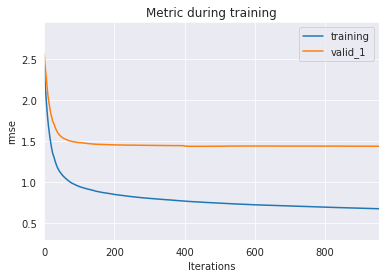

In [98]:
print('Training and Validation Error of the Model')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
#In the initial round we started with the 1.466 RMSE of the validation error, and in the final iteration we received 1.41 RMSE for the validation set, 0.05 point decrease, 
#which is a 5 percent improvement overall.
#Training error decreased more rapidly through the iterations from 0.95 to 0.66, 0.27 point decrease. 
#This shows that the model learns faster from the training set and this is a consequence of model is trained with the same set of training set in every iteration.
#We learned one thing from the initial parameter set round and the iterations:
#Both training and validation errors decreased, so if I set the num_boost rounds to a higher number, I would probably achieve less RMSE in the cost of higher runtimes.
#Gap between training and validation error increased, so this is a sign of we are overfitting, to eliminate the possibility of overfitting 
#I will introduce cross-validation into the model rather than hyperparameter tuning.

In [99]:
del lgb_model
del train_dataset
del valid_dataset
del X_train
del X_valid
del y_train
del y_valid
gc.collect()

87

#Kfold Splits 

In [100]:
# cretae kfold object and empty model and evaluation lists
kf = KFold(n_splits=4, shuffle=False)
models = []
evaluations = []
#Recall that, We initially manually split train and test split into 4 pieces, allocated first 3 quarters as training set and last quarter as validation set.
#Now, We are going to iteratively run the model on the 75% of the training data and see if RMSE will improve.
#We are going to use KFold, and split X to 4 pieces and run light GBM iteratively on the each fold.
#Here is a quick visual from scikit-learn's website of how Kfold performs splits:

In [101]:
# dynamically split X and y with the k-fold split indexes

for train_index, valid_index in kf.split(X):
    X_train_rf = X.loc[train_index]
    y_train_rf = y.loc[train_index]
    
    X_valid_kf = X.loc[valid_index]
    y_valid_kf = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_rf , label=y_train_rf,
                          categorical_feature =categorical_features,
                          free_raw_data=False)
    d_valid = lgb.Dataset(X_valid_kf , label=y_valid_kf,
                          categorical_feature =categorical_features,
                          free_raw_data=False)
    evaluation_result = {}
    
    model = lgb.train(initial_params,
                      train_set = d_train,
                      num_boost_round = 900,
                      valid_sets=[d_train, d_valid],
                      verbose_eval = 100,
                      early_stopping_rounds=500,
                      evals_result=evaluation_result)
    models.append(model)
    evaluations.append(evaluation_result)
    
    del X_train_rf, y_train_rf, X_valid_kf, y_valid_kf, d_train, d_valid
    gc.collect()

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.992502	valid_1's rmse: 1.38617
[200]	training's rmse: 0.883518	valid_1's rmse: 1.35678
[300]	training's rmse: 0.829074	valid_1's rmse: 1.35192
[400]	training's rmse: 0.794106	valid_1's rmse: 1.3461
[500]	training's rmse: 0.76627	valid_1's rmse: 1.34239
[600]	training's rmse: 0.743651	valid_1's rmse: 1.34102
[700]	training's rmse: 0.723932	valid_1's rmse: 1.34045
[800]	training's rmse: 0.705802	valid_1's rmse: 1.34034
[900]	training's rmse: 0.691303	valid_1's rmse: 1.33897
Did not meet early stopping. Best iteration is:
[900]	training's rmse: 0.691303	valid_1's rmse: 1.33897
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.995142	valid_1's rmse: 1.42672
[200]	training's rmse: 0.887417	valid_1's rmse: 1.40963
[300]	training's rmse: 0.835721	valid_1's rmse: 1.40636
[400]	training's rmse: 0.796777	valid_1's rmse: 1.40666
[500]	training's rmse: 0.764714	valid_1's rm

Training and validation Error of First Fold


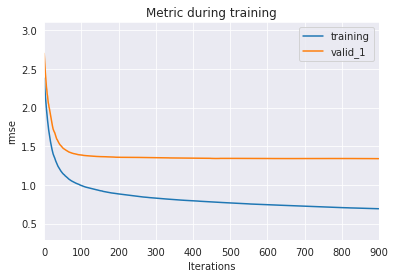

In [102]:
print('Training and validation Error of First Fold')
ax = lgb.plot_metric(evaluations[0],metric='rmse')
plt.show()

Training and Validation Error of the Second Fold


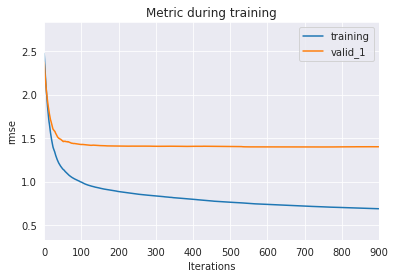

In [103]:
print('Training and Validation Error of the Second Fold')
ax = lgb.plot_metric(evaluations[1], metric='rmse')
plt.show()

Training and Validation Error of the Third Fold


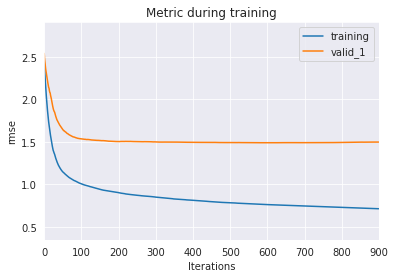

In [104]:
print('Training and Validation Error of the Third Fold')
ax = lgb.plot_metric(evaluations[2], metric='rmse')
plt.show()

Training and Validation Error of the Third Fold


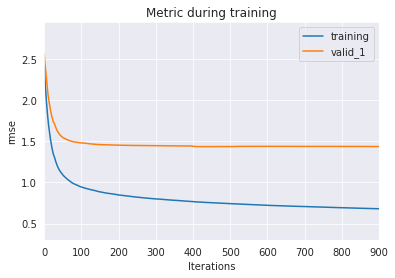

In [105]:
print('Training and Validation Error of the Third Fold')
ax = lgb.plot_metric(evaluations[3], metric='rmse')
plt.show()

#Time Series Split


In [106]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
models = []
evaluations = []

In [107]:
for train_index, valid_index in tscv.split(X):
    X_train_rf = X.loc[train_index]
    y_train_rf = y.loc[train_index]
    
    X_valid_tscv = X.loc[valid_index]
    y_valid_tscv = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_rf , label=y_train_rf,
                          categorical_feature =categorical_features,
                          free_raw_data=False)
    d_valid = lgb.Dataset(X_valid_tscv , label=y_valid_tscv,
                          categorical_feature =categorical_features,
                          free_raw_data=False)
    evaluation_result = {}
    
    model = lgb.train(initial_params,
                      train_set = d_train,
                      num_boost_round = 900,
                      valid_sets=[d_train, d_valid],
                      verbose_eval = 100,
                      early_stopping_rounds=500,
                      evals_result=evaluation_result)
    models.append(model)
    evaluations.append(evaluation_result)
    
    del X_train_rf, y_train_rf, X_valid_tscv, y_valid_tscv, d_train, d_valid
    gc.collect()

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.74936	valid_1's rmse: 1.8038
[200]	training's rmse: 0.650959	valid_1's rmse: 1.79245
[300]	training's rmse: 0.601718	valid_1's rmse: 1.79277
[400]	training's rmse: 0.572493	valid_1's rmse: 1.79333
[500]	training's rmse: 0.547381	valid_1's rmse: 1.79571
[600]	training's rmse: 0.528466	valid_1's rmse: 1.79937
[700]	training's rmse: 0.512332	valid_1's rmse: 1.80379
Early stopping, best iteration is:
[256]	training's rmse: 0.620288	valid_1's rmse: 1.78983
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.877687	valid_1's rmse: 1.7497
[200]	training's rmse: 0.788286	valid_1's rmse: 1.65596
[300]	training's rmse: 0.74272	valid_1's rmse: 1.61173
[400]	training's rmse: 0.70592	valid_1's rmse: 1.60402
[500]	training's rmse: 0.679432	valid_1's rmse: 1.59943
[600]	training's rmse: 0.659704	valid_1's rmse: 1.60324
[700]	training's rmse: 0.644102	valid_1's rmse: 1.6061
[800]

Training and Validation Error of the Second Fold


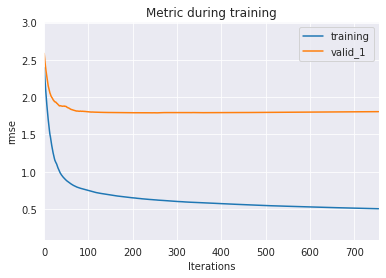

In [108]:
print('Training and Validation Error of the Second Fold')
ax = lgb.plot_metric(evaluations[0], metric='rmse')
plt.show()

Training and Validation Error of the Second Fold


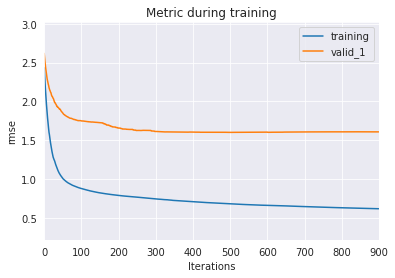

In [109]:
print('Training and Validation Error of the Second Fold')
ax = lgb.plot_metric(evaluations[1], metric='rmse')
plt.show()

Training and Validation Error of the Second Fold


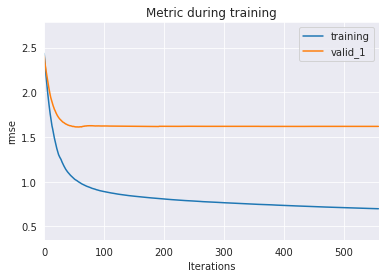

In [110]:
print('Training and Validation Error of the Second Fold')
ax = lgb.plot_metric(evaluations[2], metric='rmse')
plt.show()

#Train data without null values

In [111]:
train.isnull().sum()

building_id                      0
timestamp                        0
meter_reading                    0
site_id                          0
primary_use                      0
square_feet                      0
age                              0
day_of_month                 22347
month                        22347
air_temperature              22347
cloud_coverage               22347
dew_temperature              22347
precip_depth_1_hr            22347
sea_level_pressure           22347
wind_speed                   22347
air_temperature_mean_lag3    22539
dew_temperature_mean_lag3    22566
day_of_week                  22347
hour                         22347
is_weekend                   22347
season                       22347
wind_compass_direction       22347
log_meter_reading                0
dtype: int64

In [112]:
New_train = train.dropna()

In [113]:
New_train

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,age,day_of_month,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3,day_of_week,hour,is_weekend,season,wind_compass_direction,log_meter_reading
0,161,2016-01-01 00:00:00,0.00000,2,0,11329,54.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,0.00000
1,162,2016-01-01 00:00:00,0.00000,2,0,98829,54.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,0.00000
2,163,2016-01-01 00:00:00,4.57190,2,0,72102,52.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,1.71774
3,166,2016-01-01 00:00:00,209.88600,2,4,553210,13.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,5.35132
4,167,2016-01-01 00:00:00,0.00000,2,4,86323,66.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182435,1409,2016-12-31 23:00:00,18.81200,15,4,48881,120.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,2.98629
4182436,1410,2016-12-31 23:00:00,16.70000,15,6,11524,28.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,2.87356
4182437,1411,2016-12-31 23:00:00,0.00000,15,0,9111,64.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,0.00000
4182438,1412,2016-12-31 23:00:00,0.00000,15,4,39538,69.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,0.00000


In [114]:
New_train.isnull().sum()

building_id                  0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
age                          0
day_of_month                 0
month                        0
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_speed                   0
air_temperature_mean_lag3    0
dew_temperature_mean_lag3    0
day_of_week                  0
hour                         0
is_weekend                   0
season                       0
wind_compass_direction       0
log_meter_reading            0
dtype: int64

In [115]:
New_train.describe()

,building_id,meter_reading,site_id,primary_use,square_feet,age,day_of_month,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3,day_of_week,hour,is_weekend,season,wind_compass_direction,log_meter_reading
count,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000,4159874.00000
mean,885.04954,632.82245,9.24928,2.81565,126962.89565,52.37869,15.77025,6.64019,NaN,NaN,NaN,NaN,NaN,NaN,16.75147,7.09763,3.00499,11.51933,0.28593,1.53153,1.32685,4.25345
std,430.49979,7998.31250,4.99480,3.07087,118670.90346,16.49650,8.84187,3.41535,0.00000,0.00000,0.00000,NaN,NaN,0.00000,11.67280,10.54843,1.99630,6.92198,0.45186,1.11128,1.12946,2.52578
min,7.00000,0.00000,0.00000,0.00000,4314.00000,6.00000,1.00000,1.00000,-28.90625,0.00000,-35.00000,-1.00000,981.50000,0.00000,-28.59896,-34.76042,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,747.00000,11.50112,6.00000,0.00000,51471.00000,54.00000,8.00000,4.00000,8.89844,0.00000,-1.09961,0.00000,1011.00000,1.50000,9.03125,-0.93327,1.00000,6.00000,0.00000,1.00000,0.00000,2.52582
50%,989.00000,121.78150,9.00000,1.00000,91273.00000,54.00000,16.00000,7.00000,18.29688,2.00000,7.80078,0.00000,1015.00000,2.59961,18.36719,7.60026,3.00000,12.00000,0.00000,2.00000,1.00000,4.81041
75%,1241.00000,467.00000,14.00000,6.00000,168696.00000,54.00000,23.00000,10.00000,25.59375,3.50000,16.09375,0.00000,1020.00000,4.10156,25.36458,15.92969,5.00000,18.00000,1.00000,3.00000,2.00000,6.14847
max,1413.00000,880374.00000,15.00000,14.00000,861524.00000,120.00000,31.00000,12.00000,47.18750,9.00000,26.09375,343.00000,1044.00000,16.50000,47.18750,25.59375,6.00000,23.00000,1.00000,3.00000,3.00000,13.68810


#Linear Regression

In [116]:
Training = New_train.loc["0":"4000000"]
Testing = New_train.loc["4000000":"4160093"]

In [117]:
from sklearn import linear_model

In [118]:
Linear_Reg = linear_model.LinearRegression()
Training_features = Training[initial_feature_list]
Training_Target = Training['log_meter_reading']


In [119]:
Training_features

,age,site_id,building_id,wind_speed,cloud_coverage,primary_use,wind_compass_direction,sea_level_pressure,is_weekend,day_of_week,day_of_month,month,hour,precip_depth_1_hr,season,square_feet,air_temperature_mean_lag3,dew_temperature,dew_temperature_mean_lag3,air_temperature
0,54.00000,2,161,3.59961,6.00000,0,2.00000,1015.50000,0.00000,4.00000,1.00000,1.00000,0.00000,0.00000,0.00000,11329,15.60156,-5.60156,-5.60156,15.60156
1,54.00000,2,162,3.59961,6.00000,0,2.00000,1015.50000,0.00000,4.00000,1.00000,1.00000,0.00000,0.00000,0.00000,98829,15.60156,-5.60156,-5.60156,15.60156
2,52.00000,2,163,3.59961,6.00000,0,2.00000,1015.50000,0.00000,4.00000,1.00000,1.00000,0.00000,0.00000,0.00000,72102,15.60156,-5.60156,-5.60156,15.60156
3,13.00000,2,166,3.59961,6.00000,4,2.00000,1015.50000,0.00000,4.00000,1.00000,1.00000,0.00000,0.00000,0.00000,553210,15.60156,-5.60156,-5.60156,15.60156
4,66.00000,2,167,3.59961,6.00000,4,2.00000,1015.50000,0.00000,4.00000,1.00000,1.00000,0.00000,0.00000,0.00000,86323,15.60156,-5.60156,-5.60156,15.60156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999996,54.00000,9,949,1.50000,2.00000,4,1.00000,1016.50000,0.00000,4.00000,16.00000,12.00000,13.00000,0.00000,0.00000,86786,11.10156,8.29688,7.39844,11.10156
3999997,54.00000,9,951,1.50000,2.00000,6,1.00000,1016.50000,0.00000,4.00000,16.00000,12.00000,13.00000,0.00000,0.00000,103924,11.10156,8.29688,7.39844,11.10156
3999998,54.00000,9,952,1.50000,2.00000,0,1.00000,1016.50000,0.00000,4.00000,16.00000,12.00000,13.00000,0.00000,0.00000,218024,11.10156,8.29688,7.39844,11.10156
3999999,54.00000,9,953,1.50000,2.00000,1,1.00000,1016.50000,0.00000,4.00000,16.00000,12.00000,13.00000,0.00000,0.00000,563782,11.10156,8.29688,7.39844,11.10156


In [120]:
Training_Target

0         0.00000
1         0.00000
2         1.71774
3         5.35132
4         0.00000
            ...  
3999996   4.25751
3999997   5.18555
3999998   5.76252
3999999   6.17575
4000000   6.62939
Name: log_meter_reading, Length: 3978143, dtype: float32

In [121]:
Linear_Reg.fit(Training_features, Training_Target)

LinearRegression()

In [122]:
Testing_features = Testing[initial_feature_list]
Testing_Targets = Testing['log_meter_reading']


In [123]:
Prediction = Linear_Reg.predict(Testing_features)

In [124]:
Comparison = pd.DataFrame(Prediction,index = Testing_Targets.index, columns = ["LR_Prediction"])

In [125]:
Comparison

,LR_Prediction
4000000,4.92489
4000001,4.33808
4000002,3.63502
4000003,3.85343
4000004,4.51014
...,...
4160089,2.94652
4160090,3.35824
4160091,2.70587
4160092,2.13263


In [126]:
Comparison = Comparison.join(Testing_Targets)

In [127]:
Comparison.head(100)

,LR_Prediction,log_meter_reading
4000000,4.92489,6.62939
4000001,4.33808,6.13432
4000002,3.63502,4.16087
4000003,3.85343,5.15253
4000004,4.51014,5.12761
...,...,...
4000095,0.07816,0.00000
4000096,1.35262,0.00000
4000097,3.44831,2.70768
4000098,0.21569,0.29535


In [128]:
Comparison_selected = Comparison.loc['4000000':'4000099']

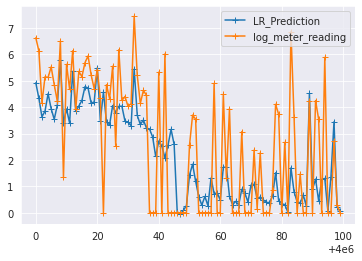

In [129]:
Comparison_selected.plot(marker='+')

In [130]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_LR_Prediction=mean_absolute_error(Prediction,Testing_Targets)
MSE_LR_Prediction=mean_squared_error(Prediction,Testing_Targets)
R2_LR_Prediction=r2_score(Prediction,Testing_Targets)

In [131]:
print("MAR_LR: "+str(round(MAE_LR_Prediction,2))+" MSE_LR: "+str(round(MSE_LR_Prediction,2))+ " R2_Score_LR: "+str(round(R2_LR_Prediction,2)))

MAR_LR: 1.74 MSE_LR: 4.59 R2_Score_LR: -1.1


#Random Forest

In [132]:
from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor()

In [133]:
X_1 = New_train[initial_feature_list]
y_1 = New_train['log_meter_reading']

In [134]:
X_train_1_training = X_1.loc['4000000':'4172439']
y_train_1_training = y_1.loc['4000000':'4172439']
X_train_1_testing = X_1.loc['4172439':'4182439']
y_train_1_testing = y_1.loc['4172439':'4182439']

In [135]:
y_train_1_training

4000000   6.62939
4000001   6.13432
4000002   4.16087
4000003   5.15253
4000004   5.12761
            ...  
4172435   0.28758
4172436   0.00000
4172437   1.70442
4172438   0.00000
4172439   6.70361
Name: log_meter_reading, Length: 171751, dtype: float32

In [136]:
RF_reg.fit(X_train_1_training,y_train_1_training)

RandomForestRegressor()

In [137]:
predicted_RF = RF_reg.predict(X_train_1_testing)

In [138]:
Comparison_RF = pd.DataFrame(predicted_RF,index=y_train_1_testing.index,columns = ["predicticted_RF"])

In [139]:
Compare_RF=Comparison_RF.join(y_train_1_testing)

In [140]:
Compare_RF

,predicticted_RF,log_meter_reading
4172439,6.70252,6.70361
4172440,4.34624,4.30367
4172441,0.00000,0.00000
4172442,0.00000,0.00000
4172443,0.00000,0.00000
...,...,...
4182435,3.05580,2.98629
4182436,2.20484,2.87356
4182437,0.00000,0.00000
4182438,0.00000,0.00000


In [141]:
Compare_RF_Selected = Compare_RF.loc['4172439':'4172539']

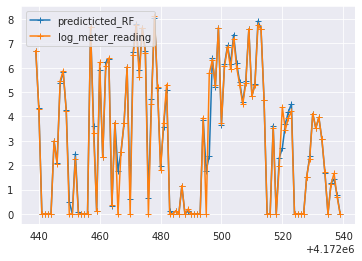

In [142]:
Compare_RF_Selected.plot(marker = '+')

In [143]:
MAE_RF_CV=mean_absolute_error(predicted_RF,y_train_1_testing)
MSE_RF_CV=mean_squared_error(predicted_RF,y_train_1_testing)
R2_RF_CV=r2_score(predicted_RF,y_train_1_testing)
print("MAR_RF_CV: "+str(round(MAE_RF_CV,2))+" MSE_RF_CV: "+str(round(MSE_RF_CV,2))+ " R2_Score_RF_CV: "+str(round(R2_RF_CV,4)))

MAR_RF_CV: 0.31 MSE_RF_CV: 0.47 R2_Score_RF_CV: 0.9135


#Linear Regression with the modifeid data

In [144]:
Modified_Train = New_train.loc[New_train['meter_reading'] != 0]

In [145]:
Modified_Train

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,age,day_of_month,month,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,air_temperature_mean_lag3,dew_temperature_mean_lag3,day_of_week,hour,is_weekend,season,wind_compass_direction,log_meter_reading
2,163,2016-01-01 00:00:00,4.57190,2,0,72102,52.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,1.71774
3,166,2016-01-01 00:00:00,209.88600,2,4,553210,13.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,5.35132
5,168,2016-01-01 00:00:00,51.55700,2,0,183460,17.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,3.96190
6,169,2016-01-01 00:00:00,176.68600,2,0,179559,16.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,5.18002
7,170,2016-01-01 00:00:00,11.28910,2,11,45224,40.00000,1.00000,1.00000,15.60156,6.00000,-5.60156,0.00000,1015.50000,3.59961,15.60156,-5.60156,4.00000,0.00000,0.00000,0.00000,2.00000,2.50871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182433,1407,2016-12-31 23:00:00,11.03250,15,4,83141,16.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,2.48761
4182434,1408,2016-12-31 23:00:00,9.41520,15,1,28760,15.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,2.34327
4182435,1409,2016-12-31 23:00:00,18.81200,15,4,48881,120.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,2.98629
4182436,1410,2016-12-31 23:00:00,16.70000,15,6,11524,28.00000,31.00000,12.00000,1.70020,2.00000,-5.60156,-1.00000,1008.50000,8.79688,2.23340,-6.50000,5.00000,23.00000,1.00000,0.00000,1.00000,2.87356


In [146]:
Modified_training = Modified_Train.loc["0" : "4000000"]
Modified_Testing = Modified_Train.loc["4000000":"4182439"]
New_Training_features = Modified_training[initial_feature_list]
New_Training_Target = Modified_training["log_meter_reading"]

In [147]:
Linear_Reg.fit(New_Training_features, New_Training_Target)

LinearRegression()

In [148]:
New_Testing_features = Modified_Testing[initial_feature_list]
New_Testing_Targets = Modified_Testing["log_meter_reading"]

In [149]:
New_Prediction = Linear_Reg.predict(New_Testing_features)

In [150]:
New_Comparison_LR = pd.DataFrame(New_Prediction,index = New_Testing_Targets.index, columns = ["LR_Prediction_NEW"])

In [151]:
New_Comparison_LR = New_Comparison_LR.join(New_Testing_Targets)

In [152]:
New_Comparison_LR.head(100)

,LR_Prediction_NEW,log_meter_reading
4000000,5.63130,6.62939
4000001,5.03616,6.13432
4000002,4.19863,4.16087
4000003,4.54675,5.15253
4000004,5.19593,5.12761
...,...,...
4000154,2.77760,3.98087
4000155,3.22737,6.84838
4000156,3.84058,7.83713
4000157,3.12992,5.95546


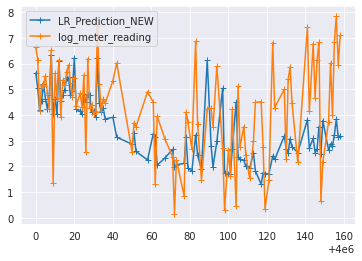

In [153]:
New_Comparison_LR_Selected = New_Comparison_LR.loc['4000000':'4000158']
New_Comparison_LR_Selected.plot(marker = "+")

In [154]:
MAE_LR_Prediction_New=mean_absolute_error(New_Prediction,New_Testing_Targets)
MSE_LR_Prediction_New=mean_squared_error(New_Prediction,New_Testing_Targets)
R2_LR_Prediction_New=r2_score(New_Prediction,New_Testing_Targets)
print("MAR_LR: "+str(round(MAE_LR_Prediction_New,2))+" MSE_LR: "+str(round(MSE_LR_Prediction_New,2))+ " R2_Score_LR: "+str(round(R2_LR_Prediction_New,2)))

MAR_LR: 1.34 MSE_LR: 2.92 R2_Score_LR: -1.16


#Random forest with the modified data 

In [155]:
X_2 = Modified_Train[initial_feature_list].copy()
y_2 = Modified_Train['log_meter_reading']

In [156]:
X_train_2_training = X_2.loc['4000000':'4172439']
y_train_2_training = y_2.loc['4000000':'4172439']
X_train_2_testing = X_2.loc['4172439':'4182439']
y_train_2_testing = y_2.loc['4172439':'4182439']

In [157]:
RF_reg.fit(X_train_2_training,y_train_2_training)

RandomForestRegressor()

In [158]:
predicted_RF_New = RF_reg.predict(X_train_2_testing)

In [159]:
Comparison_RF_New = pd.DataFrame(predicted_RF_New,index=y_train_2_testing.index,columns = ["predicticted_RF_New"])

In [160]:
Compare_RF_New=Comparison_RF_New.join(y_train_2_testing)
Compare_RF_New

,predicticted_RF_New,log_meter_reading
4172439,6.70583,6.70361
4172440,4.34487,4.30367
4172445,2.99015,2.97855
4172446,2.07804,2.04310
4172447,5.38566,5.45805
...,...,...
4182433,2.55416,2.48761
4182434,2.39600,2.34327
4182435,3.04814,2.98629
4182436,2.25387,2.87356


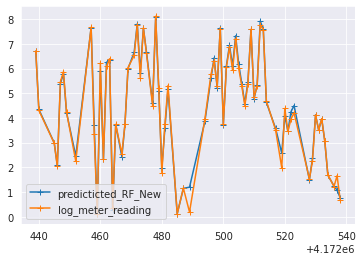

In [161]:
Compare_RF_New_selected = Compare_RF_New.loc['4172439':"4172539"]
Compare_RF_New_selected.plot(marker = '+')

In [162]:
MAE_RF_CV_New=mean_absolute_error(predicted_RF_New,y_train_2_testing)
MSE_RF_CV_New=mean_squared_error(predicted_RF_New,y_train_2_testing)
R2_RF_CV_New=r2_score(predicted_RF_New,y_train_2_testing)
print("MAR_RF_CV: "+str(round(MAE_RF_CV_New,2))+" MSE_RF_CV: "+str(round(MSE_RF_CV_New,2))+ " R2_Score_RF_CV: "+str(round(R2_RF_CV_New,4)))

MAR_RF_CV: 0.29 MSE_RF_CV: 0.26 R2_Score_RF_CV: 0.922
